In [1]:
import torch
import pandas as pd
import numpy as np
import os
import tqdm
import pytorch_lightning as pl
import torchmetrics
import torchvision
from matplotlib import pyplot as plt
from pytorch_lightning.core.lightning import LightningModule
from torch import nn
from torch.utils import data
from pytorch_lightning.callbacks.early_stopping import EarlyStopping
from PIL import Image
from torchvision import transforms
from torchinfo import summary

In [2]:
class ImageTransform():
  def __init__(self, mean=0.5, std=0.5):
    self.data_transform = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize(mean, std)
    ])

  def __call__(self, img):
    return self.data_transform(img)

class make_dataset(data.Dataset):
  def __init__(self, idx_list, file, transform, mode):
    self.file = file
    self.idx_list = idx_list
    self.mode = mode
    self.transform = transform

  def __len__(self):
    return len(self.idx_list)

  def __getitem__(self, index):
    img = self.transform(self.file[index, 1:33].reshape(8, 4))
    # if self.mode == 'train':
    #   label = self.file[index, 33].astype('int64')
    #   return img, label
    # else:
    #   return img
    img2 = torch.zeros((1,8,4))
    for i in range(4):
      img2[0, :, i] = img[0, :, 3-i]

    if self.mode == 'train':
      label = self.file[index, 33].astype('int64')
      return torch.cat([img, img2], dim=0).type('torch.FloatTensor'), label
    else:
      return torch.cat([img, img2], dim=0).type('torch.FloatTensor')

def make_dataloader(batch_size=32, valid_size=0.2):
    traindata = pd.read_csv('../data/train.csv').to_numpy()
    testdata = pd.read_csv('../data/test.csv').to_numpy()

    num_train = len(traindata)
    indices = list(range(num_train))
    np.random.shuffle(indices)
    split = np.int32(np.floor(valid_size * num_train))
    train_idx, valid_idx = indices[split:], indices[:split]

    test_idx = list(range(len(testdata)))

    train_set = make_dataset(train_idx, traindata, ImageTransform(), 'train')
    valid_set = make_dataset(valid_idx, traindata, ImageTransform(), 'train')
    test_set = make_dataset(test_idx, testdata, ImageTransform(), 'test')

    train_loader = data.DataLoader(train_set, batch_size=batch_size)
    valid_loader = data.DataLoader(valid_set, batch_size=batch_size)
    test_loader = data.DataLoader(test_set, batch_size=batch_size)

    return train_loader, test_loader, valid_loader


In [105]:
class network(pl.LightningModule):
    def __init__(self):
        super().__init__()
        self.loss_fn = nn.CrossEntropyLoss()
        self.net = nn.Sequential(
            nn.Conv2d(2,128,kernel_size=2,stride=1,padding=1),
            nn.BatchNorm2d(128),
            nn.ELU(inplace=True),
            nn.Dropout(0.5),
            nn.Conv2d(128,128,kernel_size=2,stride=1,padding=1),
            nn.BatchNorm2d(128),
            nn.ELU(inplace=True),
            nn.Dropout(0.5),

            nn.Conv2d(128,128,kernel_size=2,stride=1,padding=1),
            nn.BatchNorm2d(128),
            nn.ELU(inplace=True),
            nn.Dropout(0.5),
            nn.Conv2d(128,256,kernel_size=2,stride=1,padding=1),
            nn.BatchNorm2d(256),
            nn.ELU(inplace=True),
            nn.Dropout(0.5),
            
            nn.Conv2d(256,256,kernel_size=2,stride=1,padding=1),
            nn.BatchNorm2d(256),
            nn.ELU(inplace=True),
            nn.Dropout(0.5),
            nn.Conv2d(256,512,kernel_size=2,stride=1,padding=1),
            nn.BatchNorm2d(512),
            nn.ELU(inplace=True),
            nn.Dropout(0.5),

            nn.Conv2d(512,512,kernel_size=2,stride=1,padding=1),
            nn.BatchNorm2d(512),
            nn.ELU(inplace=True),
            nn.Dropout(0.5),
            nn.Conv2d(512,1024,kernel_size=2,stride=1,padding=1),
            nn.BatchNorm2d(1024),
            nn.ELU(inplace=True),
            nn.Dropout(0.5),

            nn.AdaptiveAvgPool2d((1, 1)),
            nn.Flatten(),
            nn.Linear(1024, 256),
            nn.BatchNorm1d(256),
            nn.ELU(inplace=True),
            nn.Dropout(0.5),

            nn.Linear(256, 4)
        )
        
    def forward(self, x):
        return self.net(x)

    def training_step(self, batch, batch_idx):
        x, target = batch
        pred = self(x)
        loss = self.loss_fn(pred, target)
        self.log("train_loss", loss)
        return loss
   
    def validation_step(self, batch, batch_idx):
        x, target = batch
        pred = self(x)
        loss = self.loss_fn(pred, target)
        acc = torchmetrics.functional.accuracy(pred, target)
        metrics = {'val_acc': acc, 'val_loss': loss}
        self.log_dict(metrics)

    def configure_optimizers(self):
        optimizer = torch.optim.Adam(self.parameters(), lr=0.001)
        return optimizer

In [106]:
def main():
    print(torch.__version__)
    print(print(torch.cuda.get_device_name(0)))

    batch_size = 128
    train_loader, test_loader, valid_loader = make_dataloader(batch_size)

    print(train_loader.dataset.__len__())
    print(valid_loader.dataset.__len__())

    print(train_loader.dataset.__getitem__(0)[0].shape)

    fig = plt.figure(figsize=(12, 24))
    for i, (imgs, labels) in enumerate(train_loader):
        print(imgs.shape)
        break
        for j in range(9):
            ax = fig.add_subplot(3, 3, j + 1)
            ax.set_xlabel(labels[j].numpy())
            plt.imshow(imgs[j][0])
        break

    model = network()

    print(summary(model, input_size=(batch_size, 2, 8, 4)))

    callbacks = [EarlyStopping(monitor="val_loss", patience=15, verbose=False)]
    trainer = pl.Trainer(max_epochs=300, gpus=1, callbacks=callbacks)
    trainer.fit(model, train_loader, valid_loader)
    

    sample_submission = pd.read_csv('../data/sample_submission.csv')
    batch_index = 0
    for i, data in enumerate(test_loader):
        outputs = model.forward(data)
        batch_index = i * batch_size
        max_vals, max_indices = torch.max(outputs, 1)
        sample_submission.iloc[batch_index:batch_index + batch_size, 1:] = max_indices.long().cpu().numpy()[:,np.newaxis]
    sample_submission.to_csv('version26.csv', index=False)

In [107]:
if __name__=='__main__':
    main()

1.11.0
NVIDIA GeForce MX250
None
1868
467
torch.Size([2, 8, 4])
torch.Size([128, 2, 8, 4])


GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Layer (type:depth-idx)                   Output Shape              Param #
network                                  --                        --
├─CrossEntropyLoss: 1-1                  --                        --
├─Sequential: 1-2                        [128, 4]                  --
│    └─Conv2d: 2-1                       [128, 128, 9, 5]          1,152
│    └─BatchNorm2d: 2-2                  [128, 128, 9, 5]          256
│    └─ELU: 2-3                          [128, 128, 9, 5]          --
│    └─Dropout: 2-4                      [128, 128, 9, 5]          --
│    └─Conv2d: 2-5                       [128, 128, 10, 6]         65,664
│    └─BatchNorm2d: 2-6                  [128, 128, 10, 6]         256
│    └─ELU: 2-7                          [128, 128, 10, 6]         --
│    └─Dropout: 2-8                      [128, 128, 10, 6]         --
│    └─Conv2d: 2-9                       [128, 128, 11, 7]         65,664
│    └─BatchNorm2d: 2-10                 [128, 128, 11, 7]         256
│


  | Name    | Type             | Params
---------------------------------------------
0 | loss_fn | CrossEntropyLoss | 0     
1 | net     | Sequential       | 4.5 M 
---------------------------------------------
4.5 M     Trainable params
0         Non-trainable params
4.5 M     Total params
17.872    Total estimated model params size (MB)


Validation sanity check:   0%|          | 0/2 [00:00<?, ?it/s]

C:\ProgramData\Anaconda3\envs\torch\lib\site-packages\pytorch_lightning\trainer\data_loading.py:132: UserWarning: The dataloader, val_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(


C:\ProgramData\Anaconda3\envs\torch\lib\site-packages\pytorch_lightning\trainer\data_loading.py:132: UserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(
C:\ProgramData\Anaconda3\envs\torch\lib\site-packages\pytorch_lightning\trainer\data_loading.py:432: UserWarning: The number of training samples (15) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.
  rank_zero_warn(


Epoch 50:  68%|██████▊   | 13/19 [00:14<00:06,  1.13s/it, loss=0.4, v_num=26]  

C:\ProgramData\Anaconda3\envs\torch\lib\site-packages\pytorch_lightning\trainer\trainer.py:688: UserWarning: Detected KeyboardInterrupt, attempting graceful shutdown...
  rank_zero_warn("Detected KeyboardInterrupt, attempting graceful shutdown...")


RuntimeError: Input type (torch.FloatTensor) and weight type (torch.cuda.FloatTensor) should be the same or input should be a MKLDNN tensor and weight is a dense tensor

<Figure size 864x1728 with 0 Axes>

Epoch 50:  68%|██████▊   | 13/19 [00:31<00:14,  2.43s/it, loss=0.4, v_num=26]

In [ ]:
import tensorboard

In [8]:
traindata = pd.read_csv('../data/train.csv').to_numpy()

(8, 4)
(8, 4)
(8, 4)
(8, 4)
(8, 4)
(8, 4)
(8, 4)
(8, 4)
(8, 4)


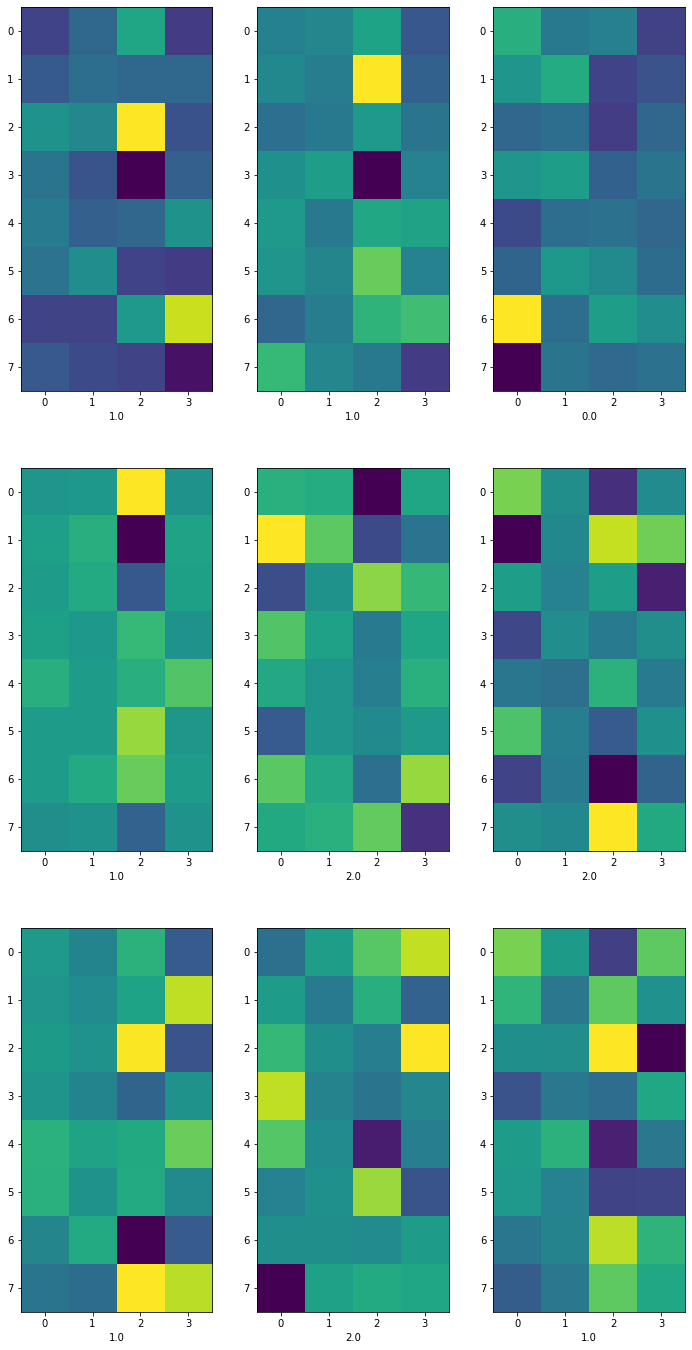

In [10]:
fig = plt.figure(figsize=(12, 24))
for j in range(9):
    img = traindata[j, 1:33].reshape((8, 4))
    label = traindata[j, 33]
    print(img.shape)
    ax = fig.add_subplot(3, 3, j + 1)
    ax.set_xlabel(label)
    plt.imshow(img)

In [11]:
fig = plt.figure(figsize=(12, 24))
for j in range(9):
    img = traindata[j, 1:33].reshape((8, 4))
    img
    for n in range(4*2-1):
        for m in range(8*2-1):
            
    label = traindata[j, 33]
    print(img)
    # ax = fig.add_subplot(3, 3, j + 1)
    # ax.set_xlabel(label)
    # plt.imshow(img)

[[ -6.1494632   -0.92971357   9.05836761  -7.01785369]
 [ -2.95847138   0.179233    -0.95659101  -0.97240086]
 [  5.95621278   4.14563573  25.01764496  -4.06125365]
 [  0.99663162  -3.83734549 -13.95699405  -2.04295728]
 [  2.13020964  -1.95766247  -1.14993047   6.08202762]
 [  0.8786122    5.09310164  -6.06664753  -7.02643577]
 [ -6.00628223  -6.00583611   7.04308355  21.88465021]
 [ -3.06415192  -5.2475518   -6.02610749 -11.9908216 ]]
[[ -2.23883638  -1.0035114    5.09807901 -10.88035741]
 [ -0.80456235  -2.99212304  26.97272407  -8.90086087]
 [ -5.96829834  -4.06013351   2.95284269  -5.04635318]
 [  1.08381865   3.97837803 -25.07254153  -2.04160214]
 [  2.91226875  -3.99803505   6.06969811   4.96618658]
 [  1.99405085  -1.13205948  14.90620531  -1.9967135 ]
 [ -7.9338059   -3.13677267   8.77421138  10.94475869]
 [  9.85818622  -0.96924102  -3.93555279 -15.89242069]]
[[ 19.08793392  -2.09251433   0.94674955 -21.83178755]
 [  9.11923488  17.85358741 -21.0699539  -15.93321192]
 [ -9.01

<Figure size 864x1728 with 0 Axes>